In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
import torch.nn as nn
from tqdm import tqdm

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]] / 10.0
dataset = torch.Tensor(s_curve).float()

num_steps = 100
betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)#previous
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)



class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, n_channels, hidden_dim=256):
        super(MLPDiffusion, self).__init__()
        
        self.linear1 = nn.Linear(n_channels, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, n_channels)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.step_embedding1 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding2 = nn.Embedding(n_steps, hidden_dim)
        self.step_embedding3 = nn.Embedding(n_steps, hidden_dim)
        
    # We use xt and step t to predict the noise
    # !!! Note that the noise is not the one added from xt-1 to xt. It is the combination of many noise.
    def forward(self, xt, t):
        x = self.linear1(xt)
        x = x + self.step_embedding1(t)
        x = self.relu1(x)
        
        x = self.linear2(x)
        x = x + self.step_embedding2(t)
        x = self.relu2(x)
        
        x = self.linear3(x)
        x = x + self.step_embedding3(t)
        x = self.relu3(x)
        
        x = self.linear4(x)

        return x


class MLPDiffusionCorrect(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusionCorrect, self).__init__()
        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2)
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units)
            ]
        )

    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        return x


def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    batch_size = x_0.shape[0]
    t = torch.randint(0, n_steps, size=(batch_size//2,))
    t = torch.cat([t, n_steps-1-t], dim=0)
    t = t.unsqueeze(-1)
    a = alphas_bar_sqrt[t]
    am1 = one_minus_alphas_bar_sqrt[t]
    e = torch.randn_like(x_0)
    x = x_0 * a + e * am1
    output = model(x, t.squeeze(-1))
    return (e-output).square().mean()






def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    cur_x = torch.rand(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    eps_theta = model(x, t)
    mean = (1 / (1-betas[t]).sqrt()) * (x - (coeff * eps_theta))
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    sample = mean + sigma_t * z
    return (sample)





seed = 1234
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 1000
plt.rc('text', color='blue')
# model = MLPDiffusionCurrect(num_steps)
model = MLPDiffusion(num_steps, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in tqdm(range(num_epoch)):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title('$q(\mathbf(x)_{'+str(i*10)+'})S')
plt.show()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
a = torch.arange(0, 10)
print(a)
print(a[::5])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 5])


[[ 3.2014775 17.75678  ]
 [15.244649  15.066147 ]
 [37.227455  22.739008 ]
 ...
 [-1.2948132 -2.0758452]
 [ 2.1820502 24.256102 ]
 [22.123201  27.20936  ]]


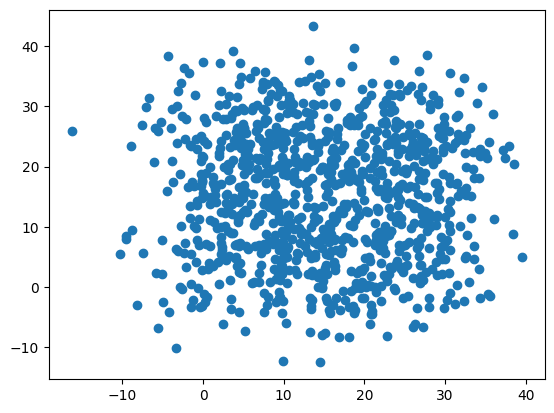

In [22]:
# model = MLPDiffusionCorrect(num_steps)
model = MLPDiffusion(num_steps, 2)


def generate_image():
    cur_x = torch.rand(1000, 2)
    
    for t in reversed(range(num_steps)):
        epsilon_theta = model(cur_x, torch.tensor([t]))
        mu_theta = 1 / alphas_bar_sqrt[t] * (cur_x - betas[t] / one_minus_alphas_bar_sqrt[t] * epsilon_theta)
        # sample
        cur_x = mu_theta + torch.randn_like(cur_x) * betas[t].sqrt()   # the value beta[t].sqrt() is hold fixed
    return cur_x

img = generate_image().detach().numpy()
print(img)
plt.scatter(img[:, 0], img[:, 1])

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())
model = model.to(device)

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
